In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: emeryntumba
Your Kaggle Key: ··········


100%|██████████| 1.62G/1.62G [00:42<00:00, 41.1MB/s]


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('ocular-disease-recognition-odir5k/full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1

In [ ]:
def is_normal(text):
    if "normal fundus" in text:
        return 1

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C == 1) & (df['left_cataract'] == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df['right_cataract'] == 1)]["Right-Fundus"].values

In [ ]:
df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))
left_normal = df.loc[(df.N ==1) & (df["left_normal"] == 1)]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.N ==1) & (df['right_normal'] == 1)]["Right-Fundus"].sample(300, random_state=42).values

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


print(len(cataract))
print(len(normal))

594
600


In [ ]:
from tqdm import tqdm
import cv2
import os, random

dataset_dir = "ocular-disease-recognition-odir5k/preprocessed_images"
labels = []
dataset = []
image_size=224

def create_dataset(image_category, label):
    processed_images = []  # Stocke les images traitées
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            # Charger l'image
            original_image = cv2.imread(image_path)

            # Convertir l'image en niveaux de gris
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            # Ajuster la luminosité à zéro
            zero_brightness_image = np.zeros_like(original_image)

            # Appliquer une vignette à 20%
            mask = np.zeros_like(gray_image)
            cv2.circle(mask, (gray_image.shape[1] // 2, gray_image.shape[0] // 2), int(min(gray_image.shape) // 2 * 0.8), 255, -1)
            vignette_image = cv2.merge([gray_image * (mask / 255.0)] * 3)

            # Ajuster la clarté à 100%
            clarity_image = cv2.detailEnhance(vignette_image, sigma_s=10, sigma_r=0.15)

            # Redimensionner l'image
            resized_image = cv2.resize(clarity_image, (image_size, image_size))

            # Normaliser les pixels entre 0 et 1
            normalized_image = resized_image / 255.0

            # Ajout de l'image normalisée et l'étiquette à la liste du dataset
            processed_images.append([np.array(normalized_image), np.array(label)])

        except Exception as e:
            print(f"Erreur lors du traitement de l'image {img}: {str(e)}")
            continue

    return processed_images

In [ ]:
# Créer les datasets pour chaque catégorie
dataset_cataract = create_dataset(cataract, 1)
dataset_normal = create_dataset(normal, 0)

# Exclure les éléments avec des images vides
dataset_cataract = [item for item in dataset_cataract if item[0] is not None]
dataset_normal = [item for item in dataset_normal if item[0] is not None]
# Concaténer les deux datasets
dataset = dataset_cataract + dataset_normal

# Mélanger le dataset
random.shuffle(dataset)


  8%|▊         | 48/594 [00:03<00:33, 16.13it/s]

Erreur lors du traitement de l'image 2102_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 23%|██▎       | 137/594 [00:11<00:38, 11.87it/s]

Erreur lors du traitement de l'image 2231_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 25%|██▍       | 147/594 [00:12<00:51,  8.73it/s]

Erreur lors du traitement de l'image 2244_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 25%|██▌       | 151/594 [00:13<00:48,  9.18it/s]

Erreur lors du traitement de l'image 2251_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 80%|████████  | 476/594 [00:51<00:10, 11.76it/s]

Erreur lors du traitement de l'image 1456_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 98%|█████████▊| 584/594 [00:59<00:00, 16.91it/s]

Erreur lors du traitement de l'image 2229_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  2%|▎         | 15/600 [00:00<00:33, 17.43it/s]

Erreur lors du traitement de l'image 2851_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 23%|██▎       | 136/600 [00:10<00:27, 16.86it/s]

Erreur lors du traitement de l'image 3320_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 35%|███▍      | 209/600 [00:15<00:23, 16.70it/s]

Erreur lors du traitement de l'image 2629_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 38%|███▊      | 226/600 [00:16<00:22, 16.66it/s]

Erreur lors du traitement de l'image 2571_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 49%|████▉     | 294/600 [00:21<00:25, 11.85it/s]

Erreur lors du traitement de l'image 3383_left.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 56%|█████▌    | 333/600 [00:24<00:16, 16.51it/s]

Erreur lors du traitement de l'image 3369_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 83%|████████▎ | 498/600 [00:36<00:08, 11.80it/s]

Erreur lors du traitement de l'image 2546_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 84%|████████▍ | 505/600 [00:37<00:06, 15.40it/s]

Erreur lors du traitement de l'image 2727_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 94%|█████████▍| 563/600 [00:42<00:04,  7.71it/s]

Erreur lors du traitement de l'image 2377_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 98%|█████████▊| 589/600 [00:46<00:01,  7.08it/s]

Erreur lors du traitement de l'image 3292_right.jpg: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



100%|██████████| 600/600 [00:50<00:00, 11.84it/s]


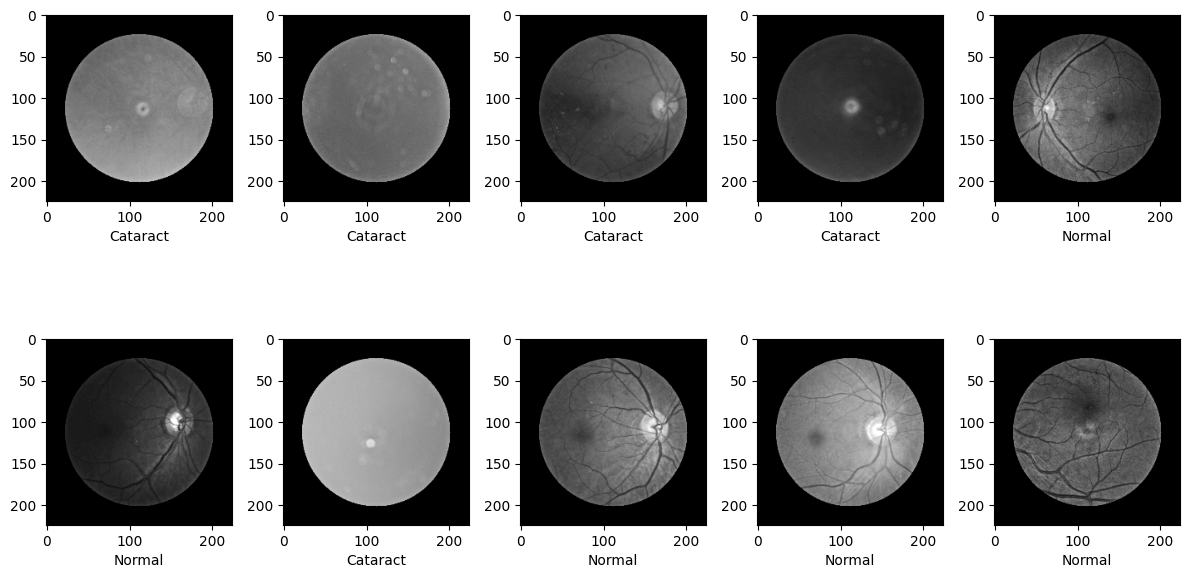

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
len(dataset)

1178

In [ ]:
# Séparer en features (x) et labels (y)
x = []
y = []
for item in dataset:
    image = item[0]
    label = item[1]
    x.append(image)
    y.append(label)

# Convertir les listes en tableaux NumPy
x = np.array(x)
y = np.array(y)

# Ajouter une dimension pour le canal
x = np.expand_dims(x, axis=-1)

# Convertir les labels en entiers
y = y.astype(int)

# Supprimer la dernière dimension
x = np.squeeze(x, axis=-1)


In [ ]:
x.shape

(1178, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split

#Diviser les données en ensembles d'entraînement et de test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
len(y_train)

589

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
epochs = 25

# Calculer le nombre initial d'images
initial_images = len(x_train)

# Calculer le nombre d'itérations par époque
steps_per_epoch = len(x_train) // batch_size

# Calculer le facteur d'augmentation total
augmentation_factor = steps_per_epoch * epochs

# Calculer le nombre total d'images après l'augmentation
total_generated_images = initial_images * augmentation_factor

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
import seaborn as sns

In [ ]:
#base model 1 InceptionV3
base_model_1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_1.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=base_model_1.input, outputs=predictions)
for layer in base_model_1.layers:
    layer.trainable = False

model_1.summary()

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
# base model 2 VGG19
base_model_2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model_2.input, outputs=x)
for layer in base_model_2.layers:
    layer.trainable = False

model_2.summary()

model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='auc')])


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# base model 3 InceptionResNetV2
base_model_3 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model_3 = Model(inputs=base_model_3.input, outputs=x)
for layer in base_model_3.layers:
    layer.trainable = False

model_3.summary()

model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='auc')])


219055592/219055592 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [ ]:
#Entrainement de bases models

# Augmentation de données pendant l'entraînement
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

model_1.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

# Calculer le nombre total d'itérations pendant toutes les époques
total_iterations = steps_per_epoch * epochs

# Afficher le nombre total d'images générées
total_generated_images = total_iterations * batch_size

# Afficher le nombre total d'images générées
print(f"\nNombre total d'images générées: {total_generated_images}")



Epoch 1/25
19/19 [==============================] - 29s 674ms/step - loss: 0.4411 - accuracy: 0.8591 - precision: 0.8453 - recall: 0.8421 - auc: 0.9455 - val_loss: 0.3787 - val_accuracy: 0.8912 - val_precision: 0.9776 - val_recall: 0.8188 - val_auc: 0.9758
Epoch 2/25
19/19 [==============================] - 10s 533ms/step - loss: 0.1701 - accuracy: 0.9457 - precision: 0.9432 - recall: 0.9361 - auc: 0.9818 - val_loss: 0.1930 - val_accuracy: 0.9286 - val_precision: 0.9728 - val_recall: 0.8938 - val_auc: 0.9844
Epoch 4/25
19/19 [==============================] - 9s 482ms/step - loss: 0.2447 - accuracy: 0.9134 - precision: 0.8909 - recall: 0.9211 - auc: 0.9702 - val_loss: 0.1828 - val_accuracy: 0.9320 - val_precision: 0.9730 - val_recall: 0.9000 - val_auc: 0.9854
Epoch 5/25
19/19 [==============================] - 8s 425ms/step - loss: 0.1459 - accuracy: 0.9559 - precision: 0.9615 - recall: 0.9398 - auc: 0.9863 - val_loss: 0.1512 - val_accuracy: 0.9388 - val_precision: 0.9277 - val_recall:

In [ ]:
model_1.save("base_model_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Entrainement de bases models

# Augmentation de données pendant l'entraînement
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

model_2.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

# Calculer le nombre total d'itérations pendant toutes les époques
total_iterations = steps_per_epoch * epochs

# Afficher le nombre total d'images générées
total_generated_images = total_iterations * batch_size

# Afficher le nombre total d'images générées
print(f"\nNombre total d'images générées: {total_generated_images}")



Epoch 1/25
19/19 [==============================] - 15s 688ms/step - loss: 0.6918 - accuracy: 0.5161 - precision: 0.5093 - recall: 0.3772 - auc: 0.5386 - val_loss: 0.6681 - val_accuracy: 0.6497 - val_precision: 0.9273 - val_recall: 0.3400 - val_auc: 0.9173
Epoch 2/25
19/19 [==============================] - 11s 613ms/step - loss: 0.6499 - accuracy: 0.7708 - precision: 0.9053 - recall: 0.5952 - auc: 0.9022 - val_loss: 0.6241 - val_accuracy: 0.9014 - val_precision: 0.8758 - val_recall: 0.9400 - val_auc: 0.9731
Epoch 3/25
19/19 [==============================] - 11s 597ms/step - loss: 0.6160 - accuracy: 0.8693 - precision: 0.8313 - recall: 0.9204 - auc: 0.9411 - val_loss: 0.5868 - val_accuracy: 0.9218 - val_precision: 0.9379 - val_recall: 0.9067 - val_auc: 0.9805
Epoch 4/25
19/19 [==============================] - 13s 689ms/step - loss: 0.5846 - accuracy: 0.9117 - precision: 0.9044 - recall: 0.9170 - auc: 0.9595 - val_loss: 0.5497 - val_accuracy: 0.9082 - val_precision: 0.8773 - val_recal

In [ ]:
model_2.save("base_model_2.h5")

In [ ]:
#Entrainement de bases models

# Augmentation de données pendant l'entraînement
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

model_3.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

# Calculer le nombre total d'itérations pendant toutes les époques
total_iterations = steps_per_epoch * epochs

# Afficher le nombre total d'images générées
total_generated_images = total_iterations * batch_size

# Afficher le nombre total d'images générées
print(f"\nNombre total d'images générées: {total_generated_images}")



Epoch 1/25
19/19 [==============================] - 41s 899ms/step - loss: 0.5798 - accuracy: 0.6944 - precision: 0.7422 - recall: 0.5779 - auc: 0.7604 - val_loss: 0.3191 - val_accuracy: 0.9150 - val_precision: 0.9699 - val_recall: 0.8600 - val_auc: 0.9683
Epoch 2/25
19/19 [==============================] - 11s 590ms/step - loss: 0.2618 - accuracy: 0.9168 - precision: 0.9317 - recall: 0.8962 - auc: 0.9658 - val_loss: 0.2078 - val_accuracy: 0.9286 - val_precision: 0.9510 - val_recall: 0.9067 - val_auc: 0.9766
Epoch 3/25
19/19 [==============================] - 12s 640ms/step - loss: 0.2094 - accuracy: 0.9270 - precision: 0.9457 - recall: 0.9031 - auc: 0.9740 - val_loss: 0.1989 - val_accuracy: 0.9320 - val_precision: 0.9577 - val_recall: 0.9067 - val_auc: 0.9787
Epoch 4/25
19/19 [==============================] - 11s 585ms/step - loss: 0.1896 - accuracy: 0.9338 - precision: 0.9464 - recall: 0.9170 - auc: 0.9780 - val_loss: 0.1820 - val_accuracy: 0.9286 - val_precision: 0.9388 - val_recal

In [ ]:
model_3.save("base_model_3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Obtention des predictions
from tensorflow import keras

pred_model_1 = keras.models.load_model('drive/MyDrive/base_model_1.h5')
pred_model_2 = keras.models.load_model('drive/MyDrive/base_model_2.h5')
pred_model_3 = keras.models.load_model('drive/MyDrive/base_model_3.h5')

predictions_base_model_1 = pred_model_1.predict(x_test)
predictions_base_model_2 = pred_model_2.predict(x_test)
predictions_base_model_3 = pred_model_3.predict(x_test)

10/10 [==============================] - 6s 272ms/step


In [ ]:
len(y_test)

295

In [ ]:
#Creation de l'ensemble de données pour le meta model
stacked_x_test = np.hstack([predictions_base_model_1, predictions_base_model_2, predictions_base_model_3])

In [ ]:
len(x_test)

295

In [ ]:
#meta model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense


adam_optimizer = Adam(learning_rate=0.01)

In [ ]:
meta_model = Sequential()
meta_model.add(Dense(256, input_dim = 3, activation='relu'))
meta_model.add(Dense(128, activation='relu'))
meta_model.add(Dense(64, activation='relu'))
meta_model.add(Dense(32, activation='relu'))
meta_model.add(layers.Dropout(0.5))
meta_model.add(Dense(1, activation='sigmoid'))
meta_model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])


In [ ]:
meta_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               1024      
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 44289 (173.00 KB)
Trainable params: 44289 

In [ ]:
meta_model.fit(stacked_x_test, y_test, epochs=100, batch_size=128)

Epoch 1/100
3/3 [==============================] - 3s 12ms/step - loss: 0.5852 - accuracy: 0.6847 - precision: 0.6228 - recall: 0.9530 - auc: 0.9159
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3696 - accuracy: 0.9356 - precision: 0.8963 - recall: 0.9866 - auc: 0.9803
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2279 - accuracy: 0.9559 - precision: 0.9789 - recall: 0.9329 - auc: 0.9586
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1497 - accuracy: 0.9661 - precision: 0.9728 - recall: 0.9597 - auc: 0.9799
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1931 - accuracy: 0.9559 - precision: 0.9416 - recall: 0.9732 - auc: 0.9826
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1278 - accuracy: 0.9661 - precision: 0.9664 - recall: 0.9664 - auc: 0.9868
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1617 - accuracy: 0.9559 - precis

In [ ]:
meta_model.save("meta_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

stacked_predictions_test = meta_model.predict(stacked_x_test)

# Évaluer les performances du modèle méta sur l'ensemble de test
predictions_binary = np.round(stacked_predictions_test)
accuracy_test = accuracy_score(y_test, predictions_binary)
precision_test = precision_score(y_test, predictions_binary)
recall_test = recall_score(y_test, predictions_binary)


print(f"Accuracy of Stacked Model on Test Set: {accuracy_test}")
print(f"Precision of Stacked Model on Test Set: {precision_test}")
print(f"Recall of Stacked Model on Test Set: {recall_test}")

10/10 [==============================] - 0s 2ms/step
Accuracy of Stacked Model on Test Set: 0.9864406779661017
Precision of Stacked Model on Test Set: 0.9865771812080537
Recall of Stacked Model on Test Set: 0.9865771812080537


In [ ]:
#Make prediction
from tensorflow import keras
import tensorflow_hub as hub

pred_model_1 = keras.models.load_model('base_model_1.h5')
pred_model_2 = keras.models.load_model('base_model_2.h5')
pred_model_3 = keras.models.load_model('base_model_3.tf')



pred_meta_model = keras.models.load_model('meta_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load image

image_path = "drive/MyDrive/mild.png"

#preprocessing
original_image = cv2.imread(image_path)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
zero_brightness_image = np.zeros_like(original_image)
mask = np.zeros_like(gray_image)
cv2.circle(mask, (gray_image.shape[1] // 2, gray_image.shape[0] // 2), int(min(gray_image.shape) // 2 * 0.8), 255, -1)
vignette_image = cv2.merge([gray_image * (mask / 255.0)] * 3)
clarity_image = cv2.detailEnhance(vignette_image, sigma_s=10, sigma_r=0.15)
resized_image = cv2.resize(clarity_image, (image_size, image_size))
normalized_image = resized_image / 255.0

data = normalized_image



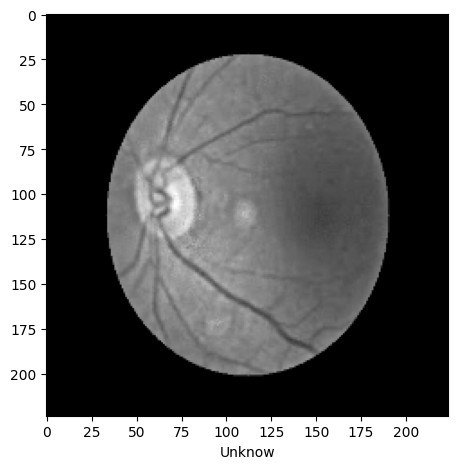

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(data)
plt.xlabel("Unknow")
plt.tight_layout()

In [ ]:
data.shape

(224, 224, 3)

In [ ]:
data_normalized = np.expand_dims(data, axis=0)
data_normalized.shape

(1, 224, 224, 3)

In [ ]:
#predictions base models

prediction_1 = pred_model_1.predict(data_normalized)
prediction_2 = pred_model_2.predict(data_normalized)
prediction_3 = pred_model_3.predict(data_normalized)

1/1 [==============================] - 5s 5s/step


In [ ]:
input_meta_model = np.hstack([prediction_1, prediction_2, prediction_3])


In [ ]:
final_prediction = meta_model.predict(input_meta_model)

1/1 [==============================] - 0s 21ms/step


In [ ]:
final_prediction

array([[0.00012968]], dtype=float32)

In [ ]:
threshold = 0.4

# Convertir la prédiction continue en classe binaire
final_class = 'cataract' if final_prediction[0, 0] > threshold else 'normal'

print("La prédiction finale est:", final_class)


La prédiction finale est: normal
